In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping


In [3]:
normal_video_directory = './videos/Normal videos'
anomaly_video_directory = './videos/Anomaly Videos'

In [4]:
def convert_to_gray(img):
    converted_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    return converted_gray

In [5]:
def resize_frame(frame):
    resized_image = cv2.resize(frame, (256, 256))
    return resized_image

In [6]:
def normalize_frame(frame):
    normalized_frame = np.divide(frame, 255.0).astype(np.float32) 
    return normalized_frame

In [7]:
def perform_frame_preprocessing(frame):
    
    resized_image = resize_frame(frame)
    gray_converted = convert_to_gray(resized_image)
    normalized_image = normalize_frame(gray_converted)
    normalized_image = np.expand_dims(normalized_image, axis=-1)
    return normalized_image

In [8]:
all_frames = []

In [9]:
files_in_directory = os.listdir(normal_video_directory)
sequence_length = 10

count = 0
for file in tqdm(files_in_directory):
    
    file_path = os.path.join(normal_video_directory, file)
    count += 1
    # if count == 21:
    #     break
    if str(file_path)[-3:] == "mp4":
        
        video_file = cv2.VideoCapture(file_path)
        file_name = file_path.split('/')[-1].split('.')[0]
        print(file_name)
        video_frames = []
        while True:
            ret, frame = video_file.read()

            #If the end of frames or any error in reading
            if not ret:
                break

            frame = perform_frame_preprocessing(frame)
            video_frames.append(frame)
        
        video_file.release()
        cv2.destroyAllWindows()
        
        frames_length = len(video_frames)
        num_sequences = frames_length // sequence_length
        video_frames = video_frames[:num_sequences * sequence_length]
        all_frames.extend(video_frames)
        video_frames = []

        

  0%|          | 0/38 [00:00<?, ?it/s]

Normal_Videos_899_x264
Normal_Videos_310_x264
Normal_Videos_317_x264
Normal_Videos_453_x264
Normal_Videos_439_x264
Normal_Videos_018_x264
Normal_Videos_781_x264
Normal_Videos_015_x264
Normal_Videos_100_x264
Normal_Videos_248_x264
Normal_Videos_247_x264
Normal_Videos_722_x264
Normal_Videos_597_x264
Normal_Videos_345_x264
Normal_Videos_360_x264
Normal_Videos_150_x264
Normal_Videos_417_x264
Normal_Videos_024_x264
Normal_Videos_246_x264
Normal_Videos_010_x264
Normal_Videos_801_x264
Normal_Videos_027_x264
Normal_Videos_641_x264
Normal_Videos_129_x264
Normal_Videos_758_x264
Normal_Videos_452_x264
Normal_Videos_881_x264
Normal_Videos_745_x264
Normal_Videos_289_x264
Normal_Videos_352_x264
Normal_Videos_365_x264
Normal_Videos_704_x264
Normal_Videos_312_x264
Normal_Videos_892_x264
Normal_Videos_929_x264
Normal_Videos_048_x264
Normal_Videos_401_x264


In [10]:
len(all_frames)

87170

In [11]:
all_frames[0].shape

(256, 256, 1)

In [12]:
type(all_frames)

list

In [13]:
type(all_frames)

list

In [14]:
def get_dataset_in_sequences():
    #defining the frame list and a sequence length
    frames_list = all_frames
    sequence_length = 10
    
    clips = []
    size = len(frames_list)
    
    for i in range(0, size, sequence_length):
        sequence_frames = frames_list[i : i + sequence_length]
        
        if len(sequence_frames) == sequence_length:
            clip = np.zeros(shape=(sequence_length, 256, 256, 1))
            for j in range(sequence_length):
                frame = sequence_frames[j]
                clip[j] = frame
            
            yield clip, clip
            
    
    
    

In [18]:
# #Defining the generator
# frames_generator = get_dataset_in_sequences()

In [19]:
# def count_sequences(generator_func):
#     count = 0
#     for _ in generator_func:
#         count += 1
#     return count

# num_sequences = count_sequences(frames_generator)
# print(f"Number of sequences produced by the generator: {num_sequences}")


Number of sequences produced by the generator: 6603


In [28]:
# for frame in frames_generator:
#     print(frame.shape)
#     break

In [15]:
#output shape and data type of the dataset
output_signature = (tf.TensorSpec(shape=(10, 256, 256, 1), dtype=tf.float32),
                    tf.TensorSpec(shape=(10, 256, 256, 1), dtype=tf.float32))

# Converting the generator into a tf.data.Dataset
dataset = tf.data.Dataset.from_generator(
    get_dataset_in_sequences,
    output_signature = output_signature
)

batch_size = 4 
dataset = dataset.batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)


2023-08-28 21:28:01.274762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [16]:
pre_trained_model = tf.keras.models.load_model('./model.hdf5')

In [17]:
pre_trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, 10, 64, 64, 128)   15616     
 stributed)                                                      
                                                                 
 layer_normalization_1 (Lay  (None, 10, 64, 64, 128)   256       
 erNormalization)                                                
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 32, 32, 64)    204864    
 stributed)                                                      
                                                                 
 layer_normalization_2 (Lay  (None, 10, 32, 32, 64)    128       
 erNormalization)                                                
                                                                 
 conv_lst_m2d_1 (ConvLSTM2D  (None, 10, 32, 32, 64)   

In [18]:
print(pre_trained_model.layers[:8])

[<keras.src.layers.rnn.time_distributed.TimeDistributed object at 0x7ff73c718580>, <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7ff73c681d30>, <keras.src.layers.rnn.time_distributed.TimeDistributed object at 0x7ff73c657bb0>, <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7ff73c679c10>, <keras.src.layers.rnn.conv_lstm2d.ConvLSTM2D object at 0x7ff73c62dd00>, <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7ff73c638190>, <keras.src.layers.rnn.conv_lstm2d.ConvLSTM2D object at 0x7ff73c62d130>, <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7ff73c5b9550>]


In [19]:
pre_trained_model.layers[5]

In [20]:
for layer in pre_trained_model.layers[:8]: 
    layer.trainable = False

# Unfreezing the final the layers (TimeDistributed with Conv2DTranspose and Conv2D)
for layer in pre_trained_model.layers[8:]:
    layer.trainable = True

In [21]:
# model checkpoint
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# loging metrics with TensorBoard
tensorboard = TensorBoard(log_dir='logs/', histogram_freq=1, write_graph=True, write_images=True)

# Stopping training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)


In [31]:
# pre_trained_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

pre_trained_model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01, decay=1e-5, epsilon=1e-6))

In [33]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('loss') < 0.0025):
            print('\nLoss fell down 0.0025, Stopping Training!')
            self.model.stop_training = True

In [34]:
callback = myCallback()

In [35]:
87170/4

21792.5

In [36]:
history = pre_trained_model.fit(
    dataset,
    epochs = 50,
    callbacks = [callback, checkpoint, tensorboard, early_stopping],
    steps_per_epoch = 2179,
    shuffle = False
)

Epoch 1/50


2023-08-25 21:50:32.388497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-25 21:50:35.489647: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2179/2179 [==============================] - 2280s 1s/step - loss: 0.0054
Epoch 2/50
2179/2179 [==============================] - 2392s 1s/step - loss: 0.0043
Epoch 3/50
2179/2179 [==============================] - 2385s 1s/step - loss: 0.0039
Epoch 4/50
2179/2179 [==============================] - 2385s 1s/step - loss: 0.0037
Epoch 5/50
2179/2179 [==============================] - 2398s 1s/step - loss: 0.0035
Epoch 6/50
2179/2179 [==============================] - 2394s 1s/step - loss: 0.0033
Epoch 7/50
2179/2179 [==============================] - 2392s 1s/step - loss: 0.0032
Epoch 8/50
2179/2179 [==============================] - 2388s 1s/step - loss: 0.0031
Epoch 9/50
2179/2179 [==============================] - 2383s 1s/step - loss: 0.0030
Epoch 10/50
2179/2179 [==============================] - 2389s 1s/step - loss: 0.0029
Epoch 11/50
2179/2179 [==============================] - 2394s 1s/step - loss: 0.0029
Epoch 12/50
2179/2179 [==============================] - 2390s 1s/step - l

In [37]:
pre_trained_model.save('./auto_encoder5.hdf5')

/usr/local/lib/python3.9/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Testing

In [9]:
import random

In [10]:
normal_test_directory = './videos/test videos/Normal Videos/'
anomaly_test_directory = './videos/test videos/Anomaly Videos/'

In [12]:
files_in_normal_directory = os.listdir(normal_test_directory)
files_in_anomaly_directory = os.listdir(anomaly_test_directory)
normal_video_file = random.choice(files_in_normal_directory)
anomaly_video_file = random.choice(files_in_anomaly_directory)

print(normal_video_file,anomaly_video_file)

normal_video_file_path = os.path.join(normal_test_directory, normal_video_file)
anomaly_video_file_path = os.path.join(anomaly_test_directory, anomaly_video_file)

.ipynb_checkpoints Robbery056_x264.mp4


In [13]:
test_frame_list = []

In [14]:
video_file = cv2.VideoCapture(anomaly_video_file_path)
video_frames = []
frame_count = 0
while True:
    ret, frame = video_file.read()

    #If the end of frames or any error in reading
    if not ret:
        break

    frame = perform_frame_preprocessing(frame)
    frame_count += 1
    test_frame_list.append(frame)
    
    if frame_count == 10:
        break


video_file.release()
cv2.destroyAllWindows()

In [15]:
def display_image(image):
    plt.imshow(image)
    plt.show()

In [16]:
def get_frames_from_video(video_file_path):
    video_file = cv2.VideoCapture(video_file_path)
    
    total_frames = 0
    original_frames_dict = {}
    
    while True:
        ret, frame = video_file.read()

        #If the end of frames or any error in reading
        if not ret:
            break
            
        total_frames += 1

        original_frames_dict[total_frames] = frame
    
    video_file.release()
    cv2.destroyAllWindows()
    
    return original_frames_dict

In [17]:
anomaly_video_file_path = 'videos/Anomaly Videos/Abuse004_x264.mp4'

In [18]:
print(anomaly_video_file_path)

videos/Anomaly Videos/Abuse004_x264.mp4


In [19]:
frames_dict = get_frames_from_video(anomaly_video_file_path)
len(frames_dict)

16794

In [20]:
def get_frames_in_batches(batch_size, frames_dict):
    count = 0
    frames_in_batch_size = []
    all_frames_list = []
    
    for i in range(1, len(frames_dict) + 1):
        count += 1
        frame = frames_dict[i]
        preprocessed_frame = perform_frame_preprocessing(frame)
        frames_in_batch_size.append(preprocessed_frame)
        
        if count == batch_size:
            count = 0
            all_frames_list.extend(frames_in_batch_size)
            frames_in_batch_size = []
            
    all_frames_array = np.array(all_frames_list)
    num_batches = all_frames_array.shape[0] // batch_size
    all_frames_in_batches = all_frames_array.reshape((num_batches, batch_size, 256, 256, 1))
    
    return all_frames_in_batches


In [26]:
all_frames_in_batches = get_frames_in_batches(30, frames_dict)

In [27]:
all_frames_in_batches.shape

(559, 30, 256, 256, 1)

In [28]:
len(all_frames_in_batches)

559

In [29]:
pre_trained_model = tf.keras.models.load_model('./auto_encoder6.hdf5')

In [ ]:
reconstructed_frames = []
for count, frame_batch in enumerate(all_frames_in_batches):
    # frame_batch = frame_batch.reshape((1, 10, 256, 256, 1))
    frame_batch = np.expand_dims(frame_batch, axis=0)
    reconstructed_frame = pre_trained_model.predict(frame_batch)
    reconstructed_frames.append(reconstructed_frame)
    print(f'Done {count + 1}')

2023-08-29 09:56:14.044931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-29 09:56:14.557042: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 9s 9s/step
Done 1
1/1 [==============================] - 0s 55ms/step
Done 2
1/1 [==============================] - 0s 53ms/step
Done 3
1/1 [==============================] - 0s 52ms/step
Done 4
1/1 [==============================] - 0s 52ms/step
Done 5
1/1 [==============================] - 0s 61ms/step
Done 6
1/1 [==============================] - 0s 50ms/step
Done 7
1/1 [==============================] - 0s 50ms/step
Done 8
1/1 [==============================] - 0s 51ms/step
Done 9
1/1 [==============================] - 0s 52ms/step
Done 10
1/1 [==============================] - 0s 51ms/step
Done 11
1/1 [==============================] - 0s 51ms/step
Done 12
1/1 [==============================] - 0s 52ms/step
Done 13
1/1 [==============================] - 0s 51ms/step
Done 14
1/1 [==============================] - 0s 52ms/step
Done 15
1/1 [==============================] - 0s 48ms/step
Done 16
1/1 [==============================] - 0s 58ms/step

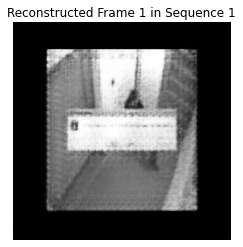

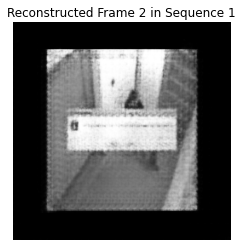

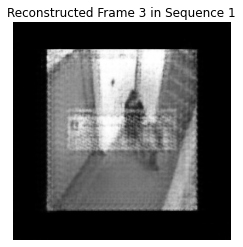

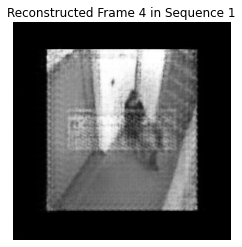

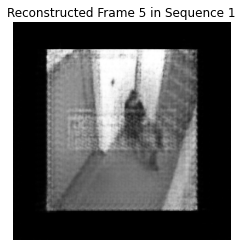

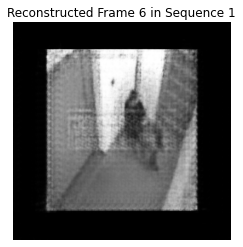

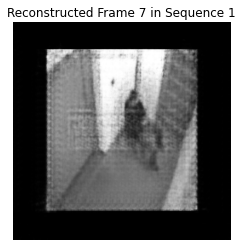

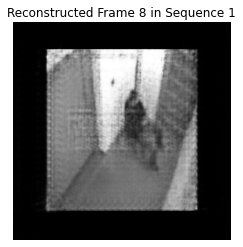

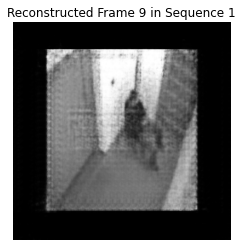

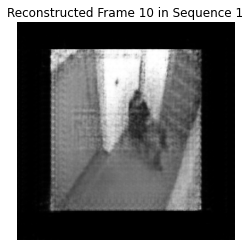

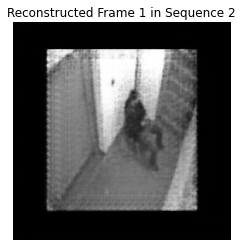

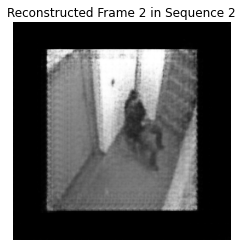

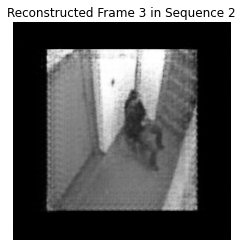

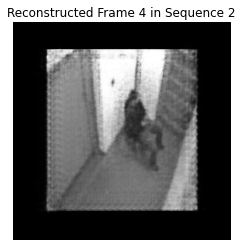

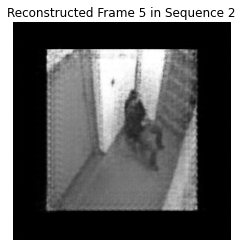

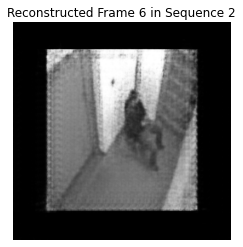

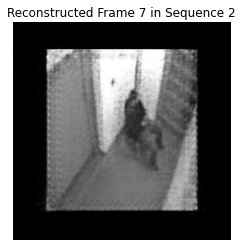

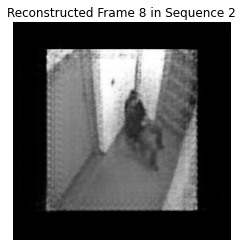

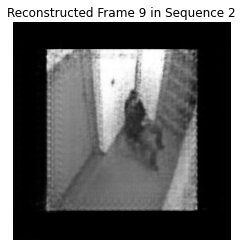

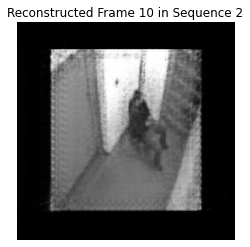

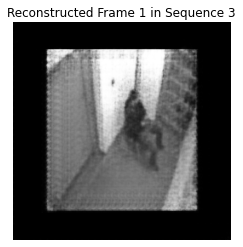

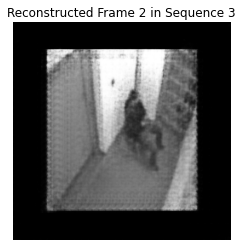

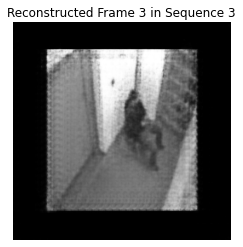

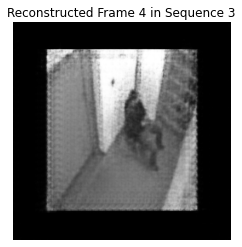

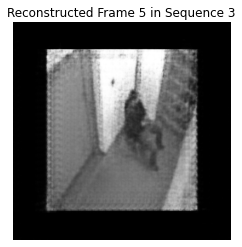

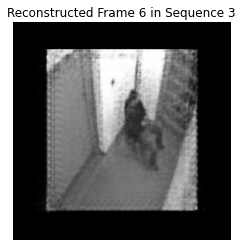

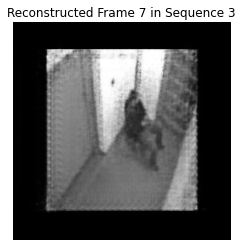

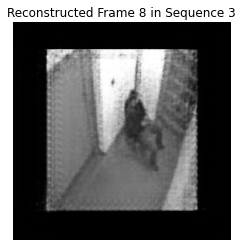

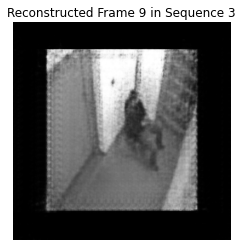

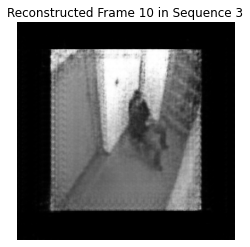

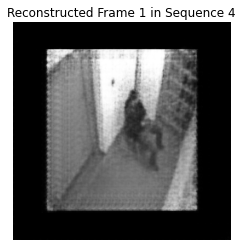

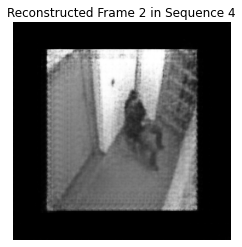

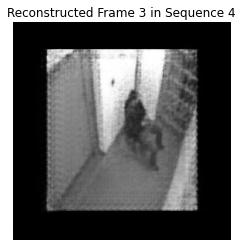

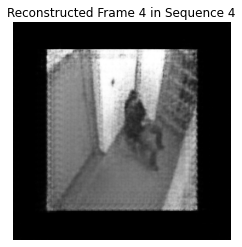

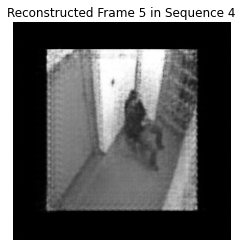

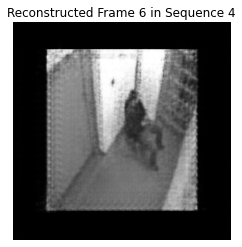

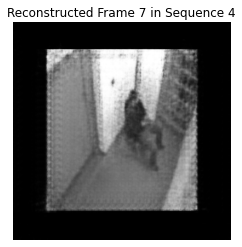

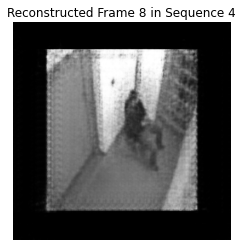

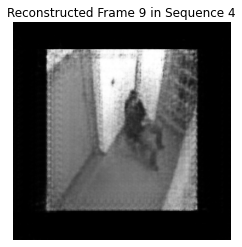

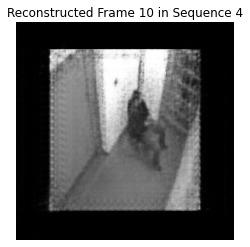

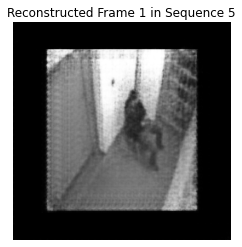

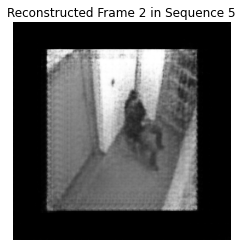

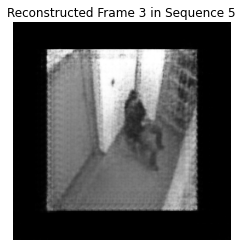

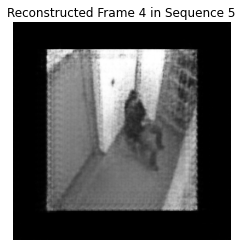

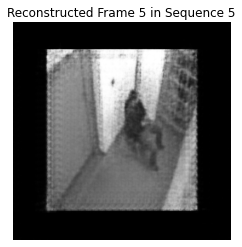

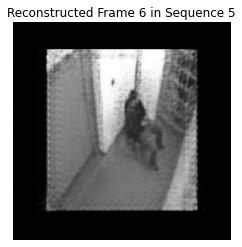

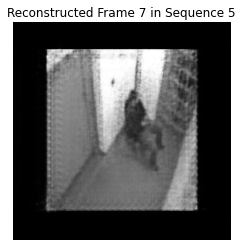

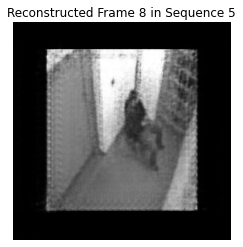

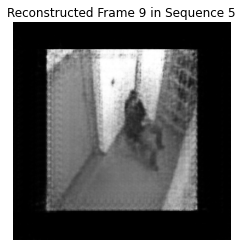

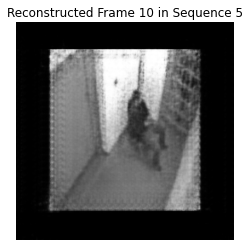

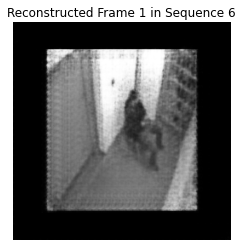

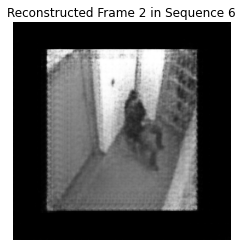

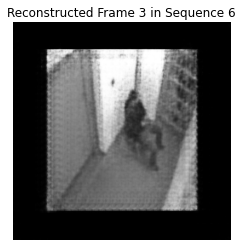

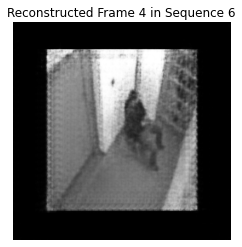

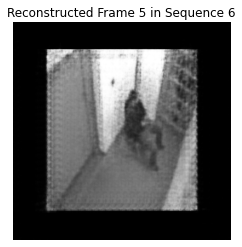

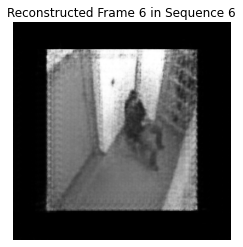

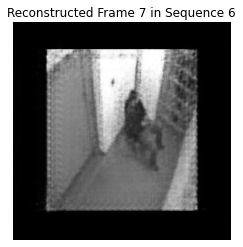

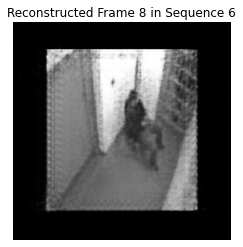

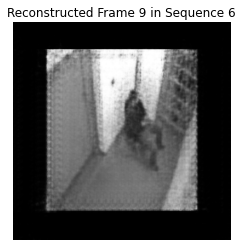

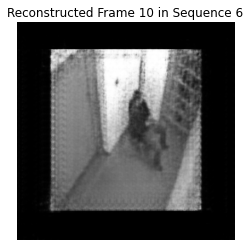

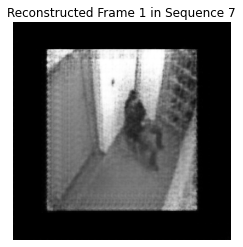

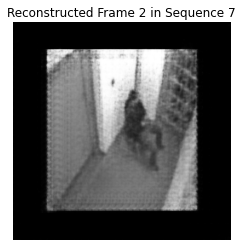

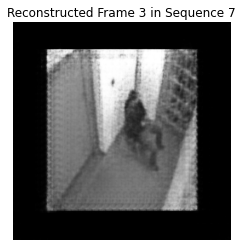

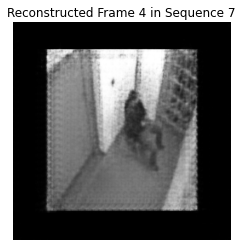

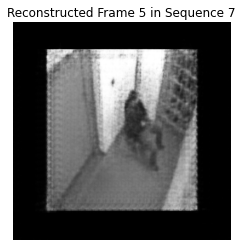

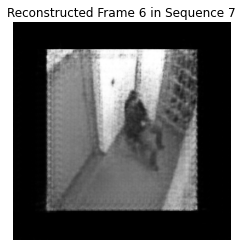

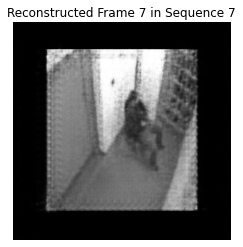

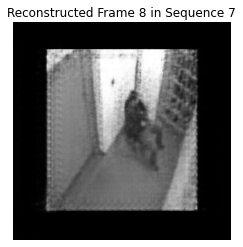

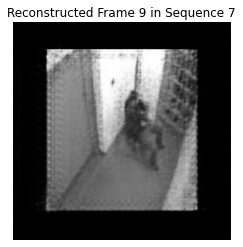

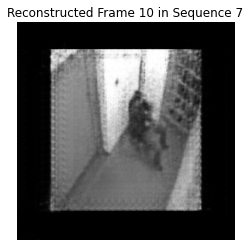

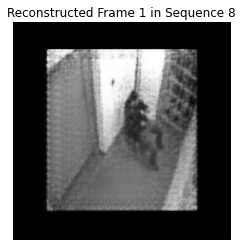

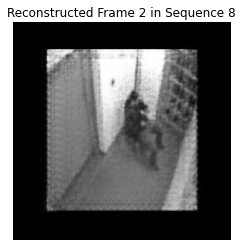

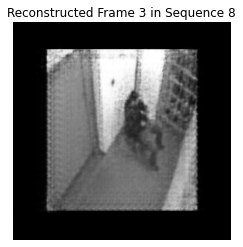

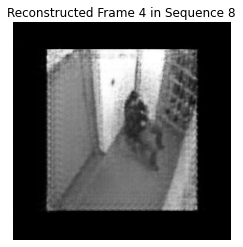

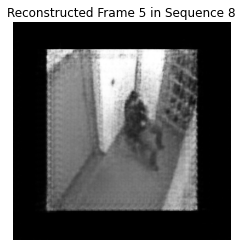

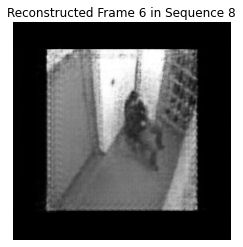

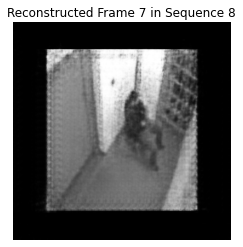

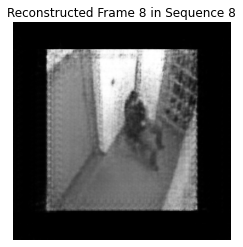

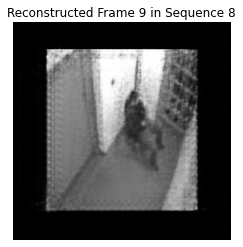

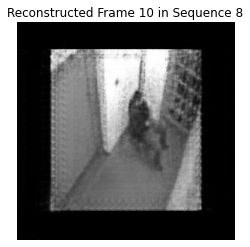

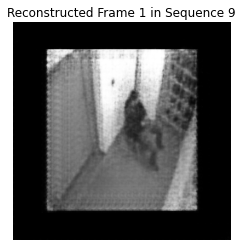

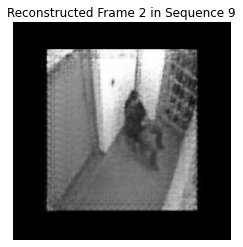

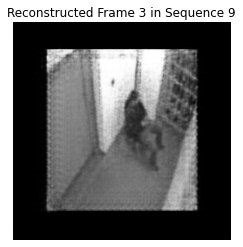

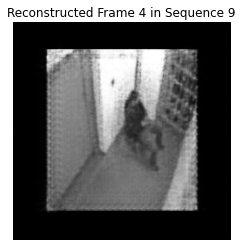

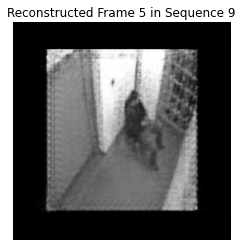

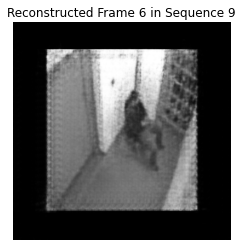

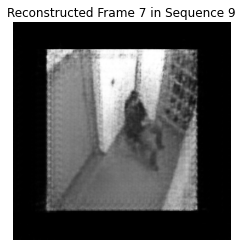

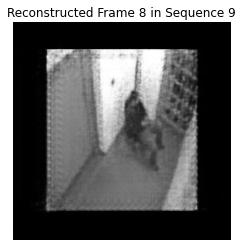

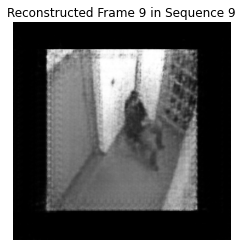

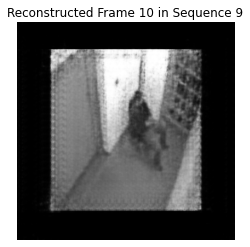

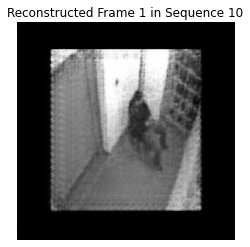

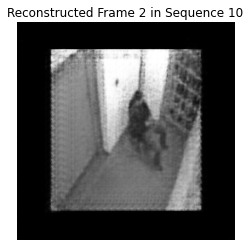

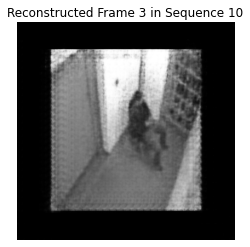

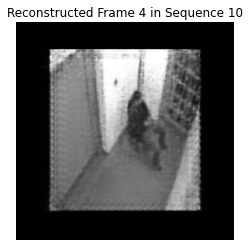

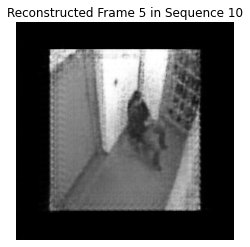

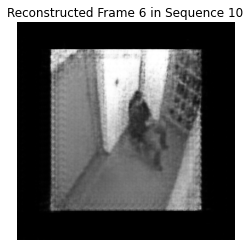

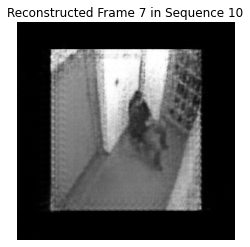

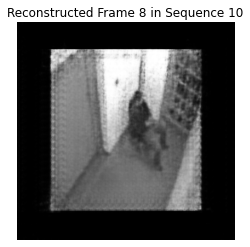

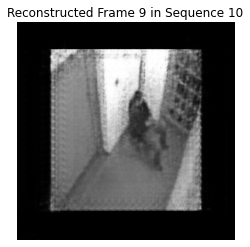

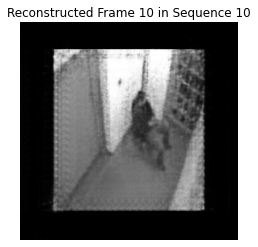

In [20]:
for i in range(10):
    predicted_sequence = reconstructed_frames[i][0]  # Extract the predicted sequence
    for j in range(10):
        reconstructed_frame = predicted_sequence[j, :, :, 0]
        plt.imshow(reconstructed_frame, cmap='gray')
        plt.title(f'Reconstructed Frame {j + 1} in Sequence {i + 1}')
        plt.axis('off')
        plt.show()

In [94]:
new_test_list = []
for entry in reconstructed_frames:
    entry.reshape(10,256,256,1)
    new_test_list.append(entry)

In [95]:
print(reconstructed_frames[0].shape)

(1, 10, 256, 256, 1)


In [51]:
len(new_test_list)

276

276


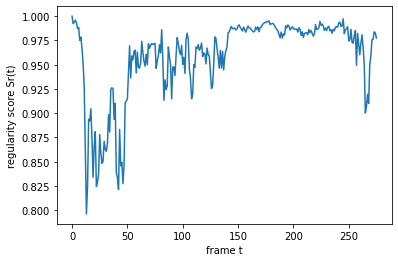

In [71]:
sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(all_frames_in_batches[i],new_test_list[i])) for i in range(0,len(new_test_list))])
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
print(len(sa))
sr = 1.0 - sa

# plot the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [53]:
to_show = frames_dict[100]

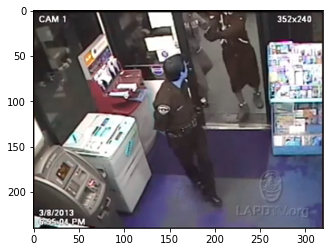

In [54]:
display_image(to_show)

1/1 [==============================] - 0s 27ms/step
Done 0
1/1 [==============================] - 0s 26ms/step
Done 1
1/1 [==============================] - 0s 26ms/step
Done 2
1/1 [==============================] - 0s 26ms/step
Done 3
1/1 [==============================] - 0s 26ms/step
Done 4
1/1 [==============================] - 0s 26ms/step
Done 5
1/1 [==============================] - 0s 26ms/step
Done 6
1/1 [==============================] - 0s 26ms/step
Done 7
1/1 [==============================] - 0s 26ms/step
Done 8
1/1 [==============================] - 0s 26ms/step
Done 9
1/1 [==============================] - 0s 26ms/step
Done 10
1/1 [==============================] - 0s 29ms/step
Done 11
1/1 [==============================] - 0s 28ms/step
Done 12
1/1 [==============================] - 0s 27ms/step
Done 13
1/1 [==============================] - 0s 26ms/step
Done 14
1/1 [==============================] - 0s 26ms/step
Done 15
1/1 [==============================] - 0s 26ms/ste

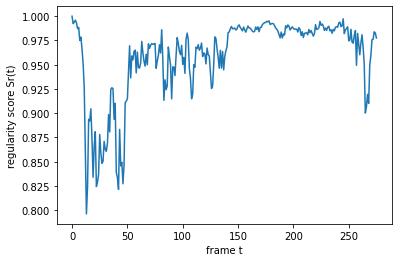

In [56]:
reconstruction_costs = []
anomalous_frame_sets = []

# Iterating over each sequence and predicting
for count, seq in enumerate(all_frames_in_batches):
    # Reshaping to have the appropriate input shape for the model
    single_sequence = np.expand_dims(seq, axis=0)
    
    # Prediction using the model
    reconstructed_sequence = pre_trained_model.predict(single_sequence)
    print(f'Done {count}')
    
    # Calculating reconstruction cost for the single sequence
    cost = np.linalg.norm(seq - reconstructed_sequence[0])
    
    # Appending the cost to list
    reconstruction_costs.append(cost)
    
    # Calculate regularity score (Sr(t)) for the current sequence
    sa = (cost - np.min(reconstruction_costs)) / np.max(reconstruction_costs)
    sr = 1.0 - sa
    
    # Check if regularity score exceeds the threshold
    if sr < 0.9:
        anomalous_frame_sets.append(count)


# Converting to numpy array for further processing
sequences_reconstruction_cost = np.array(reconstruction_costs)

# Normalizing the reconstruction costs according to the paper
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
sr = 1.0 - sa


# Plotting the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()


In [57]:
len(reconstruction_costs)

276

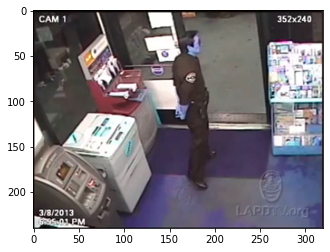

In [63]:
display_image(frames_dict[10])

In [64]:
seq_to_display = all_frames_in_batches[5]

In [65]:
len(seq_to_display)

10

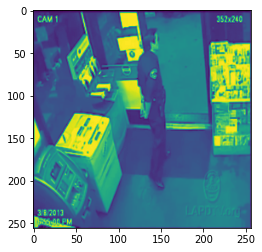

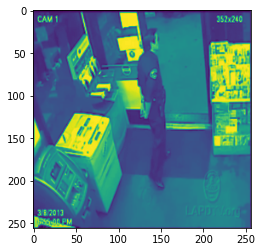

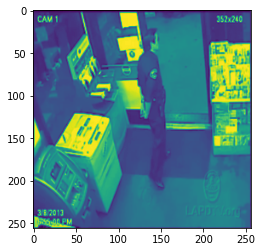

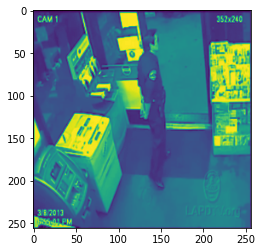

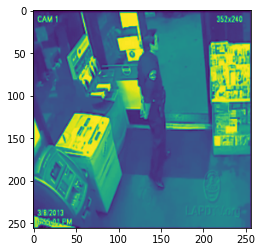

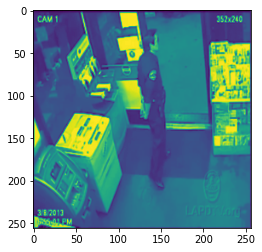

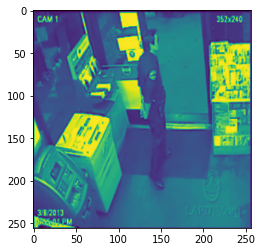

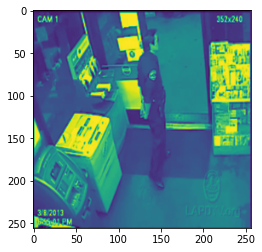

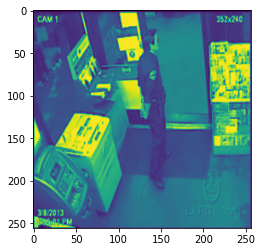

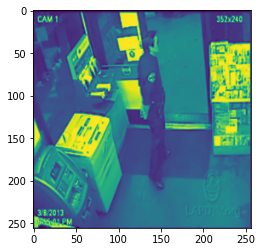

In [62]:
seq_to_display = all_frames_in_batches[0]
for seq in seq_to_display:
    display_image(seq)

In [36]:
reconstruction_costs = []
anomalous_frame_sets = []

# Iterating over each sequence and predicting
for count, seq in enumerate(all_frames_in_batches):
    # Reshaping to have the appropriate input shape for the model
    single_sequence = np.expand_dims(seq, axis=0)
        
    # Prediction using the model
    reconstructed_sequence = pre_trained_model.predict(single_sequence)
    print(f'Done {count}')
    
    # Calculating reconstruction cost for the single sequence
    cost = np.linalg.norm(seq - reconstructed_sequence[0])
    
    # Appending the cost to list
    reconstruction_costs.append(cost)
    if cost > 70.0:
        anomalous_frame_sets.append(count)
    


# # Converting to numpy array for further processing
# sequences_reconstruction_cost = np.array(reconstruction_costs)

# # Normalizing the reconstruction costs according to the paper
# sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
# sr = 1.0 - sa


# # Plotting the regularity scores
# plt.plot(reconstruction_costs)
# plt.ylabel('Cost')
# plt.xlabel('frame t')
# plt.show()


frame_sequences = np.arange(1, len(reconstruction_costs) + 1)

plt.plot(frame_sequences, reconstruction_costs)
plt.ylabel('Cost')
plt.xlabel('Frame sequence number')
plt.show()


2023-08-10 19:47:44.311654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-10 19:47:44.378951: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-10 19:47:44.628380: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 579.04MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-10 19:47:54.628936: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 322.50MiB (rounded to 338170880)requested by op sequential_1/time_distributed_4/conv2d_transpose_2/conv2d_transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current alloca

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/time_distributed_4/conv2d_transpose_2/conv2d_transpose' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.9/dist-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.9/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_214167/2068129360.py", line 10, in <cell line: 5>
      reconstructed_sequence = pre_trained_model.predict(single_sequence)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/layers/rnn/time_distributed.py", line 246, in call
      y = self.layer(inputs, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/src/layers/convolutional/conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "/usr/local/lib/python3.9/dist-packages/keras/src/backend.py", line 6252, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'sequential_1/time_distributed_4/conv2d_transpose_2/conv2d_transpose'
OOM when allocating tensor with shape[10,128,257,257] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/time_distributed_4/conv2d_transpose_2/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_2432]

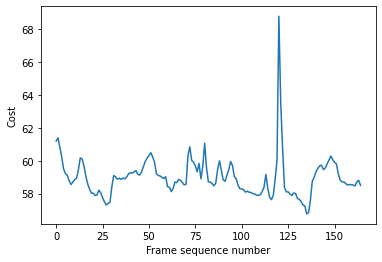

In [123]:
frame_sequences = np.arange(0, len(reconstruction_costs))

plt.plot(frame_sequences, reconstruction_costs)
plt.ylabel('Cost')
plt.xlabel('Frame sequence number')
plt.show()

In [124]:
anomalous_frame_sets

[]

In [125]:
np.min(reconstruction_costs)

56.762672

In [126]:
np.max(reconstruction_costs)

68.78362

In [127]:
np.mean(reconstruction_costs)

58.977993

72


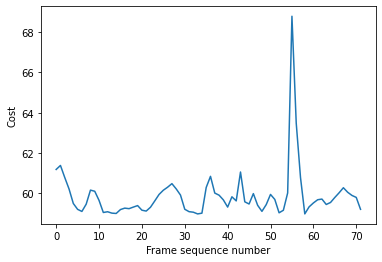

In [128]:
reconstruction_costs = np.array(reconstruction_costs)
new_cost_list = reconstruction_costs[reconstruction_costs > np.mean(reconstruction_costs)]
print(len(new_cost_list))
frame_sequences = np.arange(0, len(new_cost_list))

plt.plot(frame_sequences, new_cost_list)
plt.ylabel('Cost')
plt.xlabel('Frame sequence number')
plt.show()

In [129]:
min(reconstruction_costs)

56.762672

In [130]:
max(reconstruction_costs)

68.78362

In [131]:
np.mean(reconstruction_costs)

58.977993

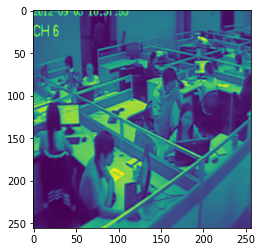

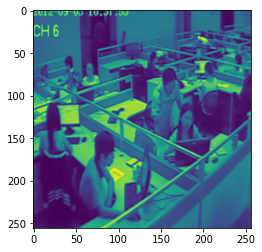

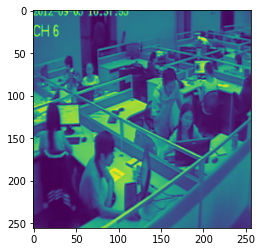

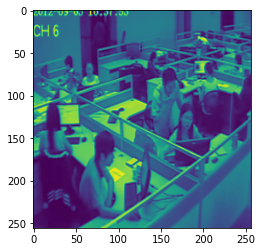

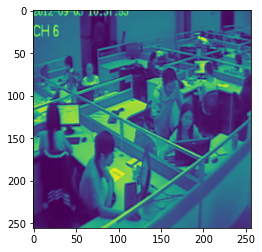

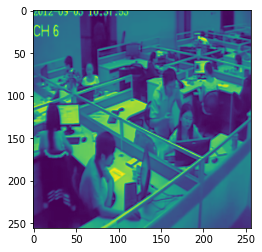

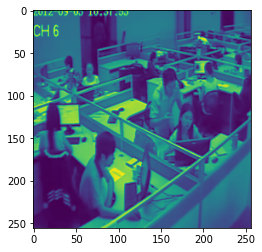

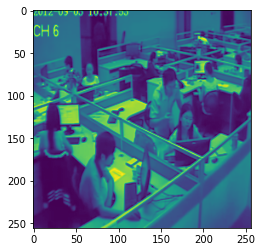

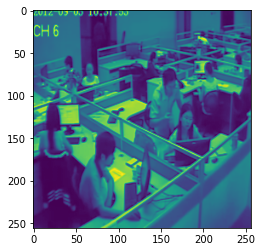

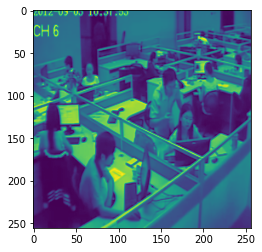

In [133]:
seq_to_display = all_frames_in_batches[124]
for seq in seq_to_display:
    display_image(seq)